# **Do You Have Malaria or Covid-19?**

Various models to predict if someone has covid-19, malaria, or is negative

# About the Problem and DataSet

Many Covid-19 positive persons (in Nigeria) say that they have syptoms of Malaria, so they treat malaria instead of the actual covid-19. Well, the truth is that they do not trust the test results (nor believe that there is covid-19 in Nigeria).

Asides from the visible symptoms of malaria and covid-19, medical lab scientists observed that malaria and covid-19 have different effects on the lymphocyte count(LYM), Granulocyte count (GRAN), the Total White Blood Cell count (WBC), and the Hemoglobin count (HGB).

For their final year research projects, my classmates collected information on the LYM, GRAN, WBC, and HGB levels of malaria and covid-19 patients as well as that of negative people.

They were able to get the details of 100 covid19 patients, 68 malaria patients, and 40 negative people from several labs. With their permission, I combined all their data to form one dataset to train models into deciding the status of someoe (covid-19, malaria, or negative) based on their lymphocyte count(LYM), Granulocyte count (GRAN), the Total White Blood Cell count (WBC), and the Hemoglobin count (HGB).

# About Me

I am Elijah Rona, I started learning data analytics (then fell in love with machine learning) early this year. I am very much in love with this profession as a student of Biology and an aspirant Mathematical Biologist. I hope to get involved in data anaytics and machine learning projects related to health, agriculture, environment (climate and the rest), and other applied science fields in the nearest future.

# Loading Libraries

In [96]:
library(tidyverse)
library(tidymodels)
library(caret)
library(caretEnsemble)
library(corrplot)
library(skimr)

# Loading Dataset

In [97]:
original <- read.csv("../input/original/CMN.csv")
head(original)

,Status,WBC,LYM,GRAN,HGB
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Covid19,4.10,1.59,2.15,14.6
2,Covid19,9.47,2.48,6.38,13.6
3,Covid19,5.10,1.73,2.98,12.8
4,Covid19,5.45,1.86,3.18,14.0
5,Covid19,4.78,0.74,3.49,15.1
6,Covid19,5.25,2.94,1.96,12.4


In [98]:
as.data.frame(skim(original))[c(1:4,17)]
apply(original[, 2:5], 2, FUN=function(x){c('min'=min(x), 'max'=max(x))})

,skim_type,skim_variable,n_missing,complete_rate,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<chr>
1,character,Status,0,1,NA
2,numeric,WBC,0,1,▇▁▁▁▁
3,numeric,LYM,0,1,▇▂▁▁▁
4,numeric,GRAN,0,1,▇▁▁▂▁
5,numeric,HGB,0,1,▁▇▇▁▁


,WBC,LYM,GRAN,HGB
min,1.33,0.26,0.28,2.9
max,61.80,78.40,108.20,27.1


As you can see from the dataset, there are no missing variables and the only non-numerical column is the target variable (the status). Also, notice that each column has a different maximum values. We have to normalize the data so that each column will have equal max values

# Train-Test Split (as well as Normalization)

It is of my best interest to split the dataset into train data and test data before normalizing it. Data normalization is a good practice to reduce the overwhelming effect of one predicator variable on another. For example, a predicator variable that counts in 100s might have greater effect on the target variable than another predicator variable that counts in 10s. To give both predicator variables unbiased attention in the model training, we perform normalization.

In [99]:
# Create the training and test datasets
set.seed(100)

# Step 1: Get row numbers for the training data
trainRowNumbers <- createDataPartition(original$Status, p=0.8, list=FALSE)

# Step 2: Create the training  dataset
trainData <- original[trainRowNumbers,]

# Step 3: Create the test dataset
testData <- original[-trainRowNumbers,]

# Store X and Y for later use.
x = trainData[, 2:5]
y = trainData$Status

Time for normalization

In [100]:
preProcess_range_model <- preProcess(trainData, method='range')
trainData <- predict(preProcess_range_model, newdata = trainData)

# Append the Y variable
trainData$Status <- y

apply(trainData[, 2:5], 2, FUN=function(x){c('min'=min(x), 'max'=max(x))})

,WBC,LYM,GRAN,HGB
min,0,0,0,0
max,1,1,1,1


As you can see, each column now has the same max value with others

In [101]:
head(trainData)

,Status,WBC,LYM,GRAN,HGB
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Covid19,0.04580784,0.017020732,0.01732765,0.4834711
2,Covid19,0.13461220,0.028410545,0.05652335,0.4421488
3,Covid19,0.06234496,0.018812388,0.02501853,0.4090909
4,Covid19,0.06813296,0.020476069,0.02687176,0.4586777
5,Covid19,0.05705308,0.006142821,0.02974426,0.5041322
7,Covid19,0.04630395,0.018684413,0.01686434,0.4958678


# *Exploratory Data Analysis (EDA)*

Before training your model, you have to understand the data. This can save you a lot of time when training the model by removing predicator variables that you feel are not so necessary in explaining the target variable.

# Boxplots and Density

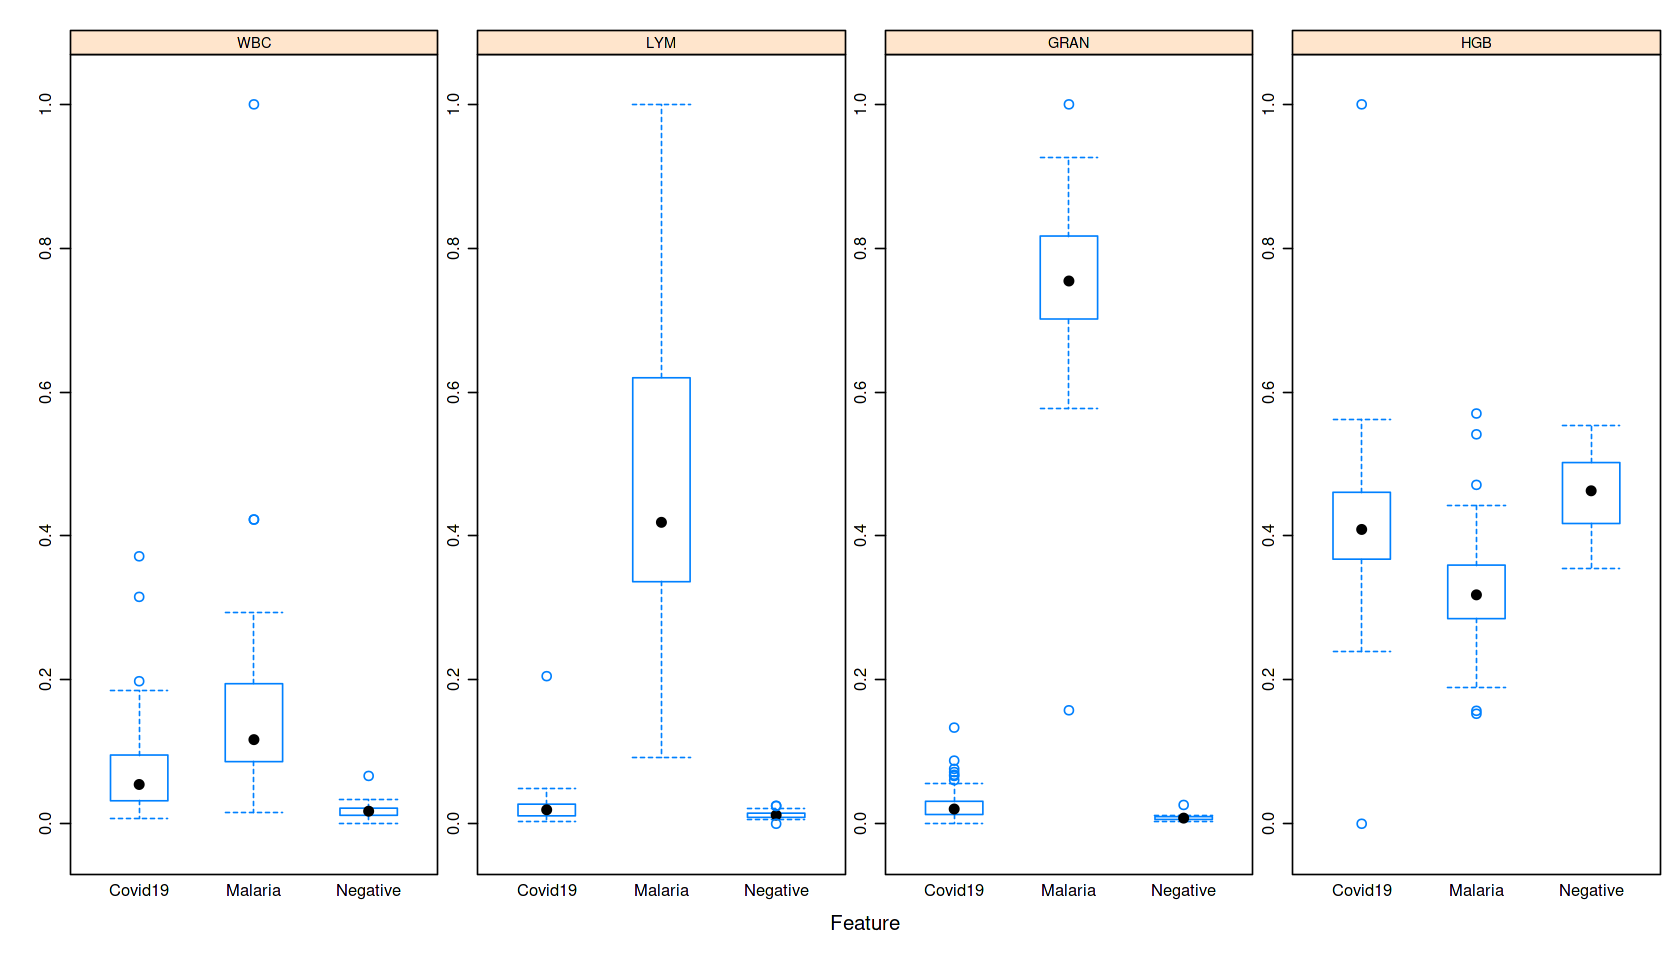

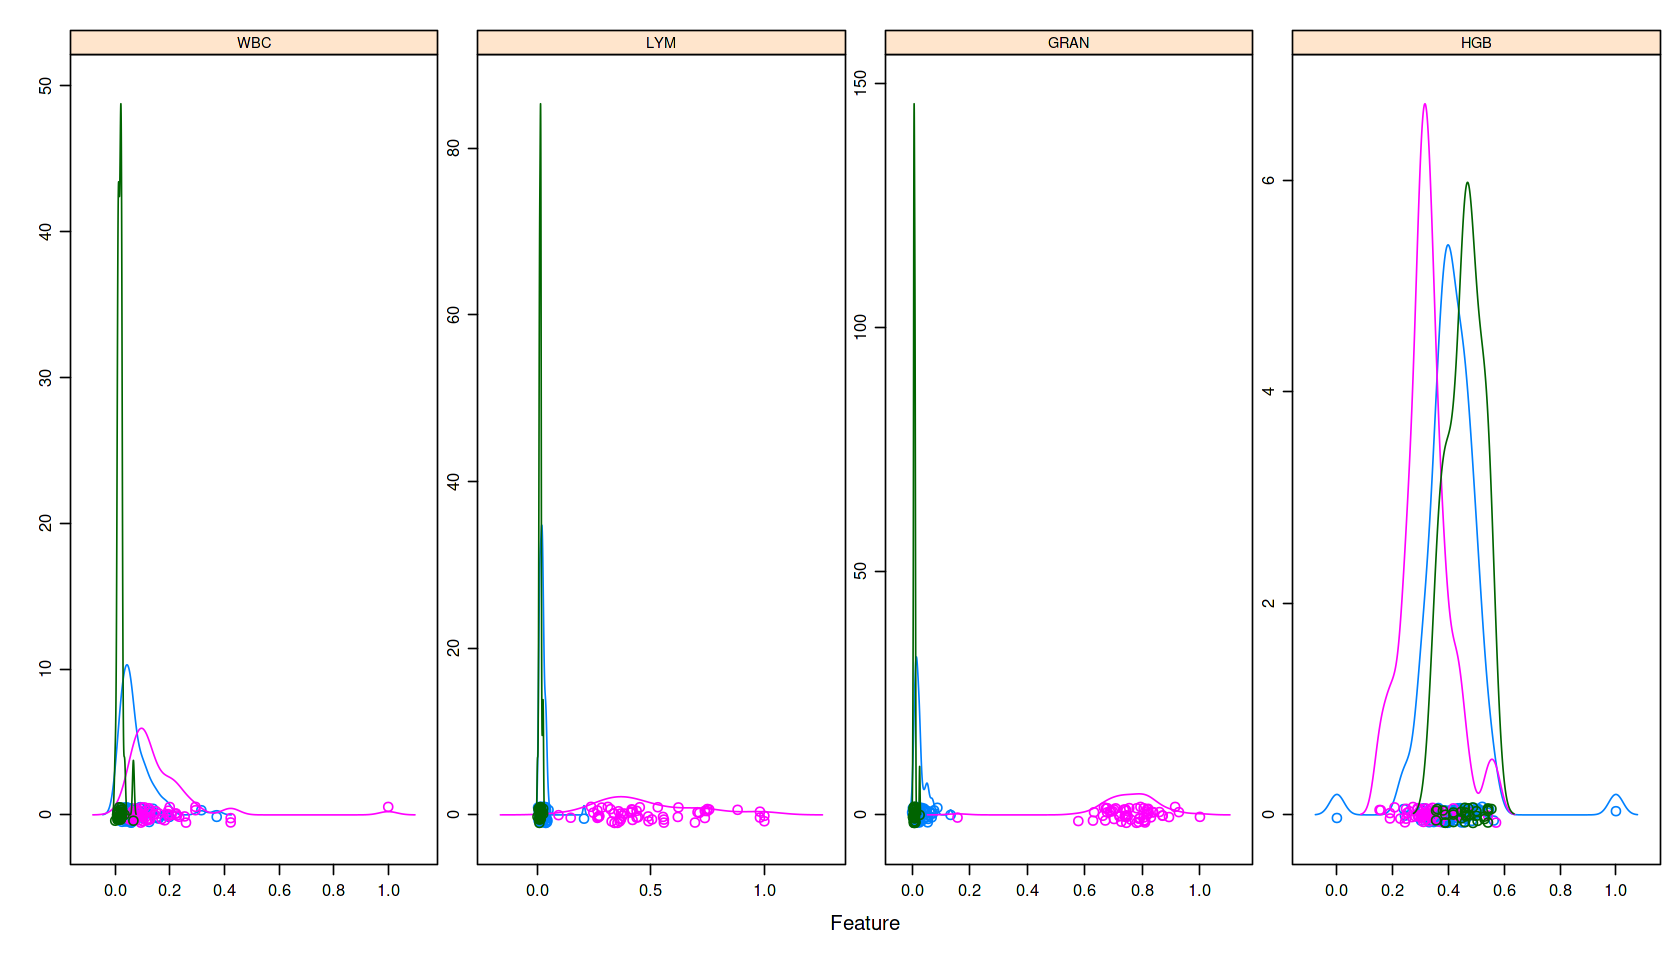

In [102]:
options(repr.plot.width = 14, repr.plot.height = 8)
trainData$Status <- as.factor(trainData$Status)
featurePlot(x = trainData[, 2:5], 
            y = trainData$Status, 
            plot = "box",
            strip=strip.custom(par.strip.text=list(cex=.7)),
            scales = list(x = list(relation="free"), 
                          y = list(relation="free")))

featurePlot(x = trainData[, 2:5], 
            y = trainData$Status, 
            plot = "density",
            strip=strip.custom(par.strip.text=list(cex=.7)),
            scales = list(x = list(relation="free"), 
                          y = list(relation="free")))

It seems as if HGB is not much of a good predicator to predict the status of someone.

# ANOVA and Post-Hoc

Before any regression (or classification) is done, ANOVA can help you by telling you if the predicator variable has significantly different values for each level in the target variable.

# White Blood Cells (Total)

In [103]:
#Anova
wbc_aov <- aov(WBC ~ Status, data = trainData)
summary(wbc_aov)

#post hoc
wbc_posthoc <- TukeyHSD(x=wbc_aov, 'Status', conf.level=0.95) #post hoc using tukey
wbc_posthoc$Status


             Df Sum Sq Mean Sq F value   Pr(>F)    
Status        2 0.4487 0.22437   25.77 1.86e-10 ***
Residuals   164 1.4281 0.00871                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,diff,lwr,upr,p adj
Malaria-Covid19,0.08632943,0.0476688,0.124990065,1.202002e-06
Negative-Covid19,-0.05402989,-0.1001954,-0.007864404,1.720411e-02
Negative-Malaria,-0.14035933,-0.1894311,-0.091287560,6.717957e-10


With a P-Value of 1.86e-10, we will use the WBC variable as a predicator because it has significant difference across the various target levels.

# Lymphocytes 

In [104]:
#Anova
lym_aov <- aov(LYM ~ Status, data = trainData)
summary(lym_aov)

#post hoc
lym_posthoc <- TukeyHSD(x=lym_aov, 'Status', conf.level=0.95) #post hoc using tukey
lym_posthoc$Status


             Df Sum Sq Mean Sq F value Pr(>F)    
Status        2  8.002   4.001   241.3 <2e-16 ***
Residuals   164  2.719   0.017                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,diff,lwr,upr,p adj
Malaria-Covid19,0.4627123,0.40937032,0.51605432,3.264056e-14
Negative-Covid19,-0.0104212,-0.07411802,0.05327563,9.208236e-01
Negative-Malaria,-0.4731335,-0.54084028,-0.40542676,3.264056e-14


With a P-Value of 2e-16, we will use the LYM variable as a predicator because it has significant difference across the various target levels. It seems that LYM is a better predicator than WBC.

# Granulocyte

In [105]:
#Anova
gran_aov <- aov(GRAN ~ Status, data = trainData)
summary(gran_aov)

#post hoc
gran_posthoc <- TukeyHSD(x=gran_aov, 'Status', conf.level=0.95) #post hoc using tukey
gran_posthoc$Status

             Df Sum Sq Mean Sq F value Pr(>F)    
Status        2 19.852   9.926    2153 <2e-16 ***
Residuals   164  0.756   0.005                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,diff,lwr,upr,p adj
Malaria-Covid19,0.72824093,0.70011392,0.75636794,3.264056e-14
Negative-Covid19,-0.01830059,-0.05188766,0.01528647,4.035488e-01
Negative-Malaria,-0.74654152,-0.78224301,-0.71084004,3.264056e-14


With a P-Value of 2e-16, we will use the GRAN variable as a predicator because it has significant difference across the various target levels. Both GRAN and LYM will have higher effects on the target variable than WBC.

# Hemoglobin 

In [106]:
#Anova
hgb_aov <- aov(HGB ~ Status, data = trainData)
summary(hgb_aov)

#post hoc
hgb_posthoc <- TukeyHSD(x=hgb_aov, 'Status', conf.level=0.95) #post hoc using tukey
hgb_posthoc$Status

             Df Sum Sq Mean Sq F value   Pr(>F)    
Status        2  0.451  0.2255   27.51 4.97e-11 ***
Residuals   164  1.344  0.0082                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,diff,lwr,upr,p adj
Malaria-Covid19,-0.09112322,-0.128630685,-0.05361575,1.298450e-07
Negative-Covid19,0.04638430,0.001595825,0.09117277,4.049276e-02
Negative-Malaria,0.13750751,0.089899450,0.18511558,4.692353e-10


The HGB variable has a P-Value of 4.97e-11. The box and density plots showed that HGB will not be a good predicator variable. Why is it now having a lower P-Value than WBC? Which between WBC and HGB will have higher effects on the status of a patient?

# *Determining the Best Predicator Variables Before Model Training*

In [107]:
set.seed(100)
options(warn=-1)

subsets <- c(1,3,5)

ctrl <- rfeControl(functions = rfFuncs,
                   method = "repeatedcv",
                   repeats = 5,
                   verbose = FALSE)

lmProfile <- rfe(x=trainData[, 2:5], y=trainData$Status,
                 sizes = subsets,
                 rfeControl = ctrl)

lmProfile


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.8352 0.7376    0.08155  0.1299         
         3   0.9116 0.8602    0.06625  0.1040        *
         4   0.9017 0.8437    0.08057  0.1290         

The top 3 variables (out of 3):
   GRAN, LYM, WBC


As you can see, WBC has higher effects on the target variable than HGB. The top three predicator variables are GRAN, LYM, and WBC. Well, instead of wasting the HGB, we will train Random Forest and XBoost models for all four predicators and also train another Random Forest and XBoost models for the three best predicator. This means that we will train four models. In the end, we will compare each model and determine the best.

# Train Control for our Models

The caret package helps us to control our models to decide the best hyperparameter values to use and also the number of folds for cross-validation

In [108]:
# Define the training control
fitControl <- trainControl(
  method = 'cv',                   # k-fold cross validation
  number = 5,                      # number of folds
  savePredictions = 'final',       # saves predictions for optimal tuning parameter
  classProbs = T,                  # should class probabilities be returned
  summaryFunction=defaultSummary  # results summary function defaultSummary  
) 

# Training the Random Forest Model (All Variables)

note: only 3 unique complexity parameters in default grid. Truncating the grid to 3 .



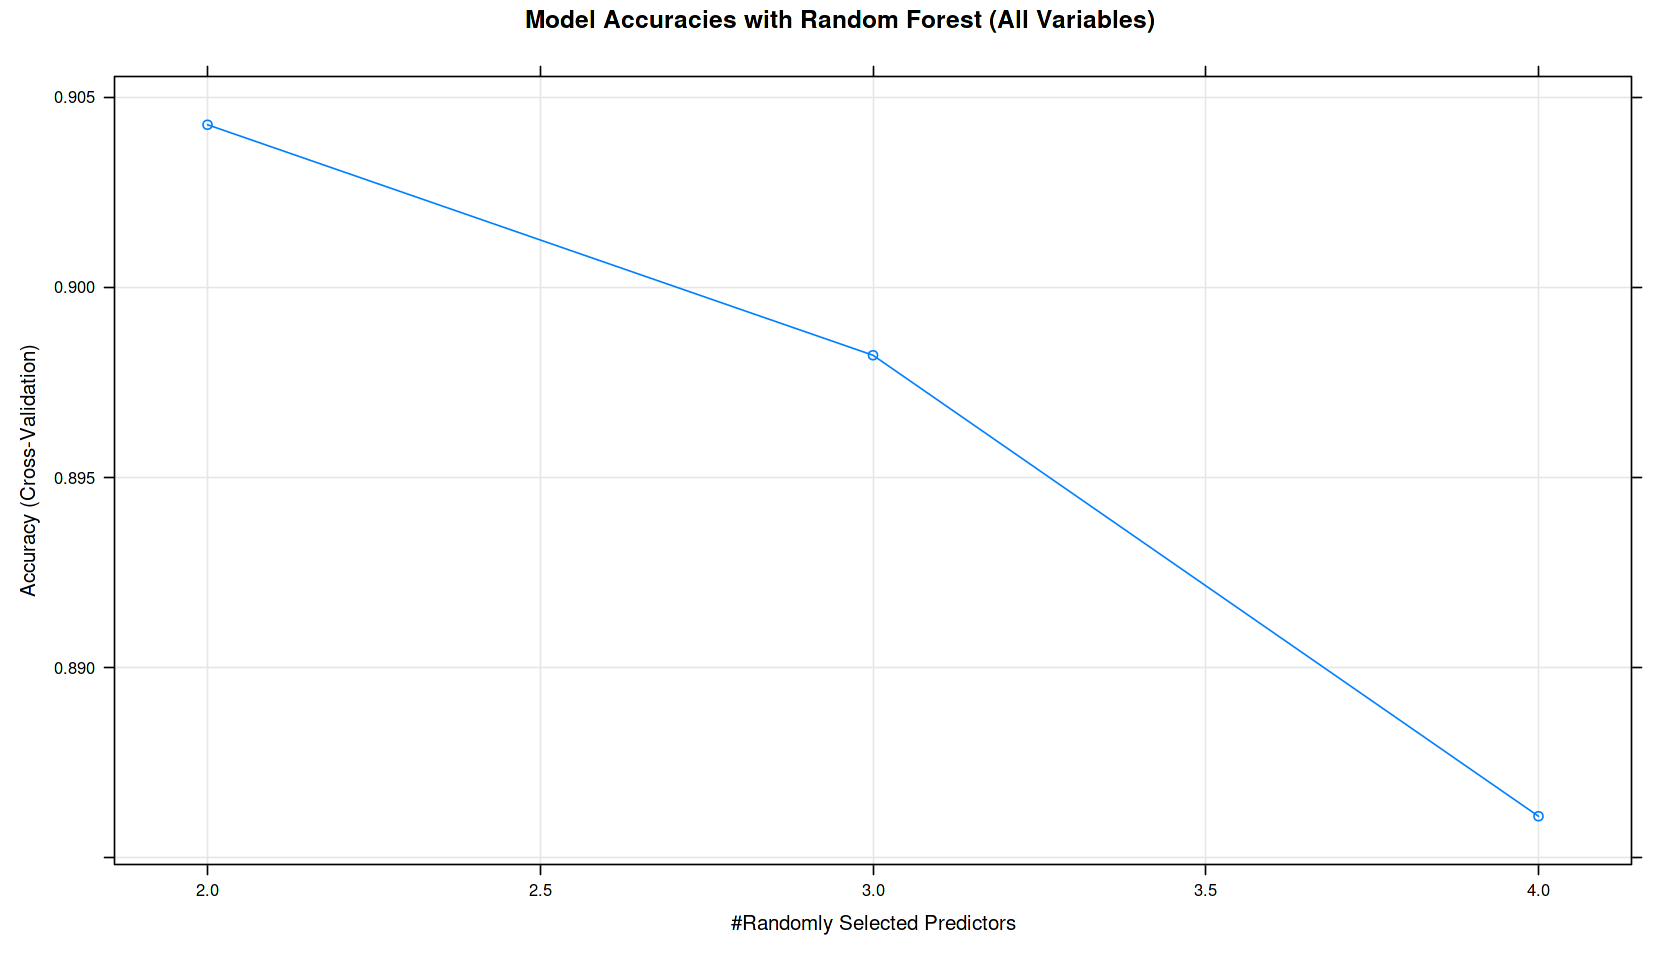

In [109]:
set.seed(100)
model_rf = train(Status ~ ., data=trainData, method='rf', tuneLength=5, trControl = fitControl)

plot(model_rf, main="Model Accuracies with Random Forest (All Variables)")

Which variables have effects on the status of patients according to the model?

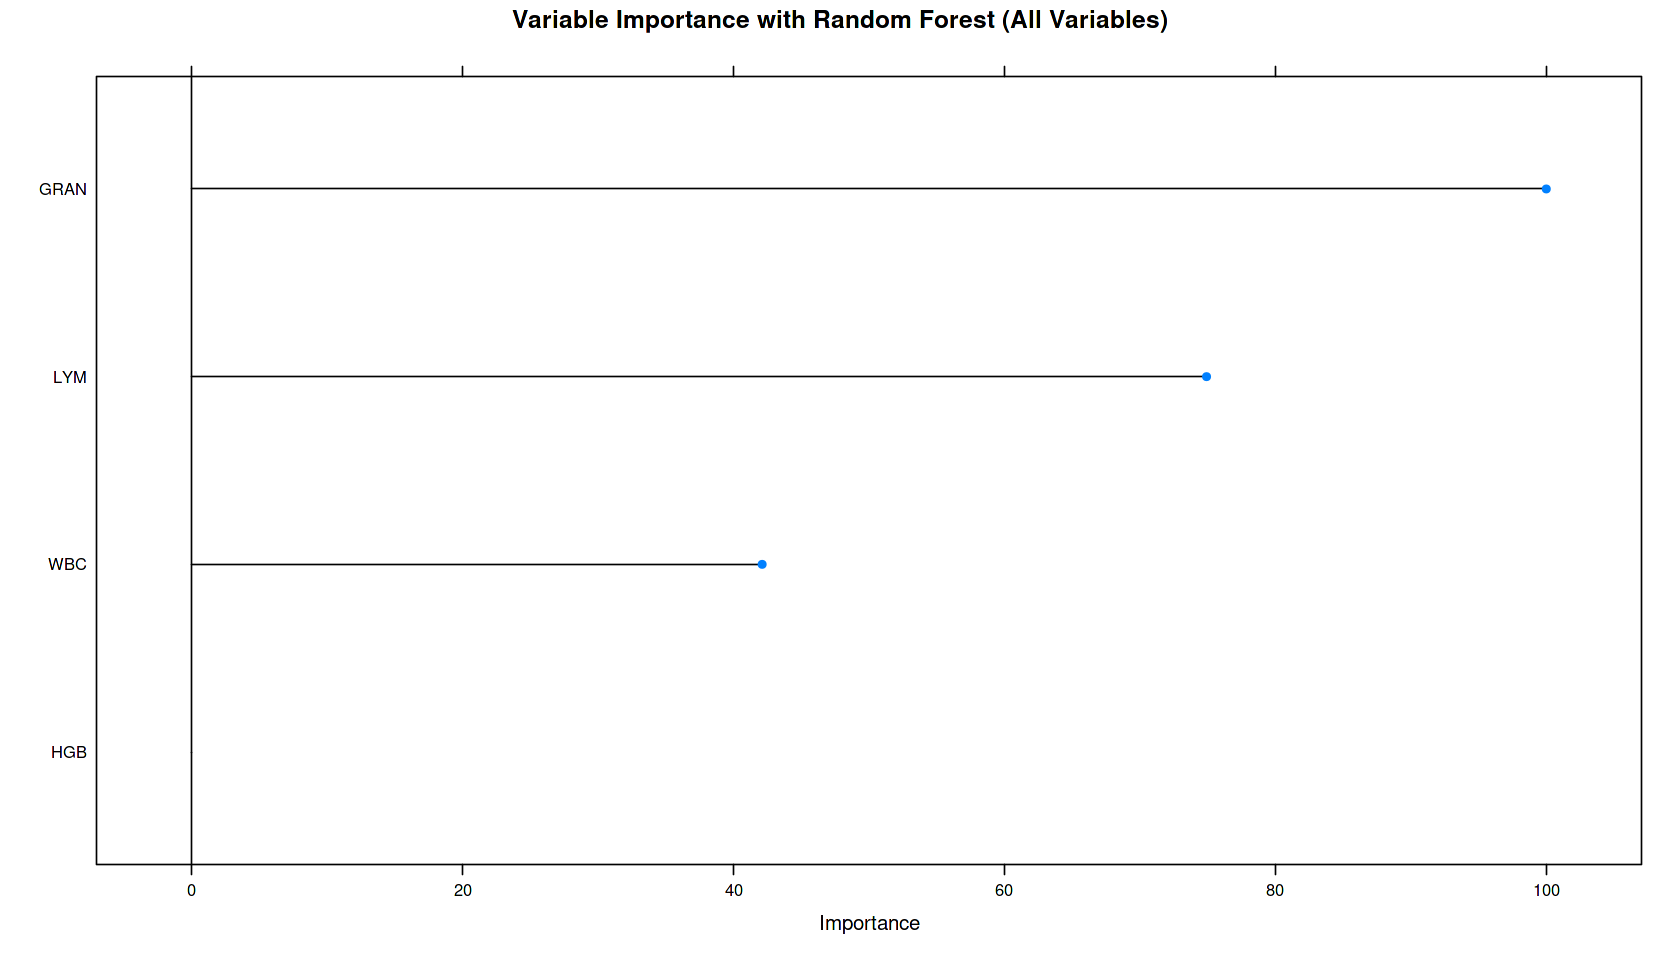

In [110]:
varimp_rf <- varImp(model_rf)
plot(varimp_rf, main="Variable Importance with Random Forest (All Variables)")

It seems that the random forest model agrees that the HGB is not so significant

# Training the XBoost Model (All Variables)

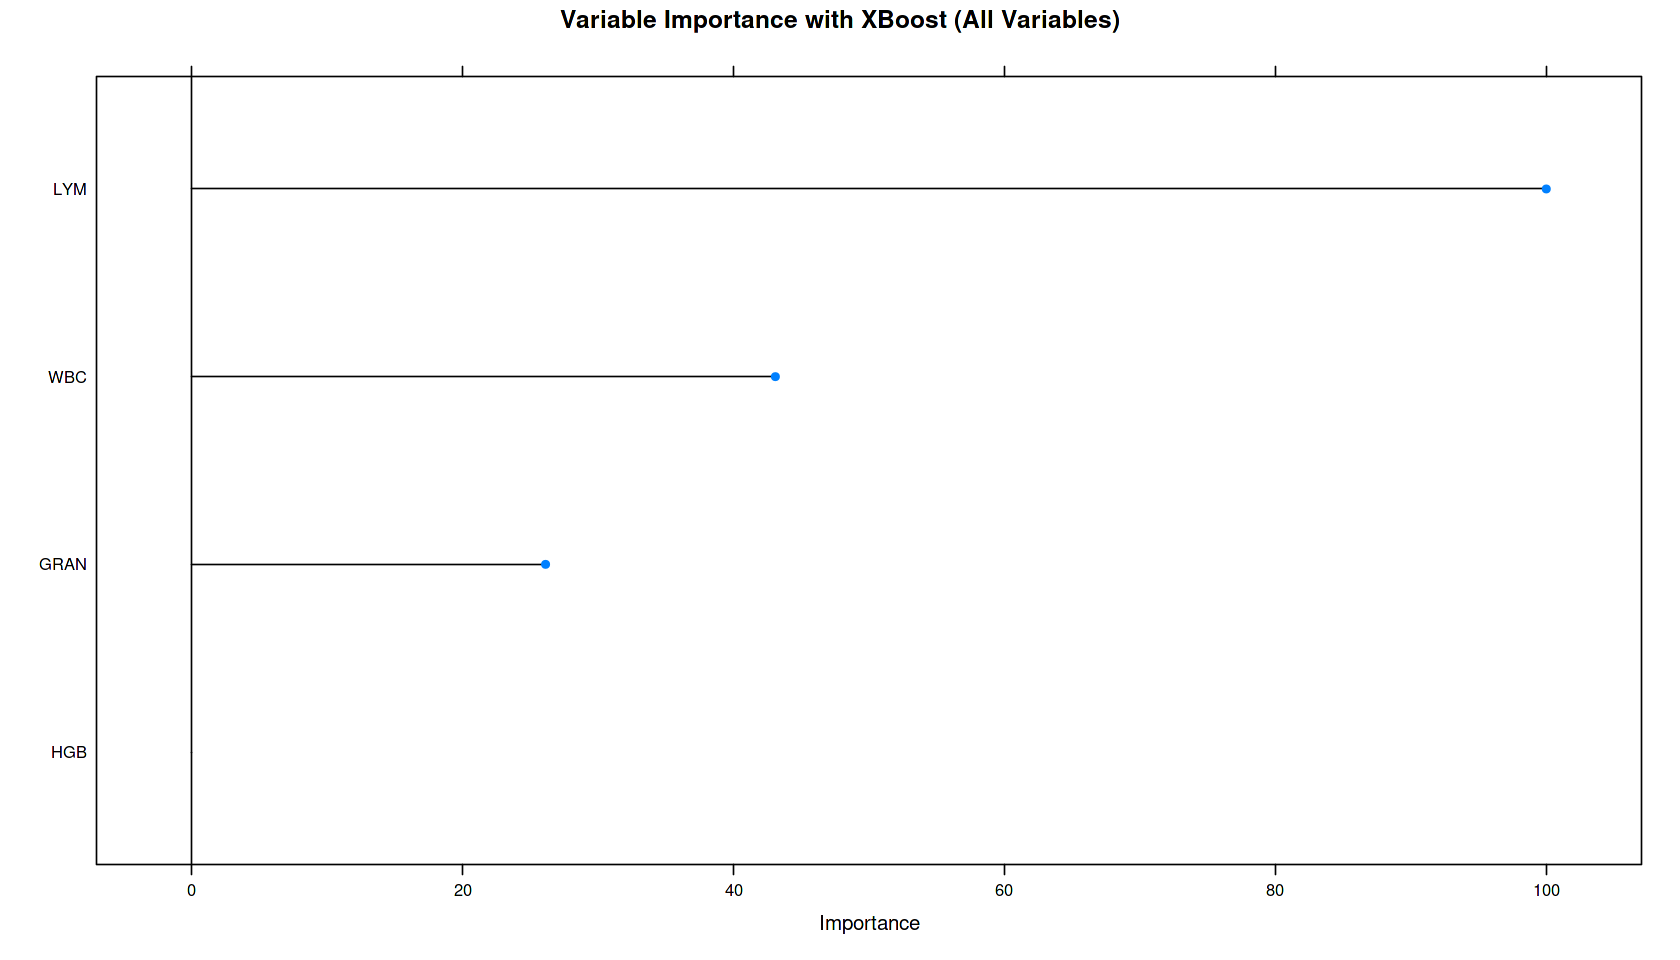

In [111]:
#XGBOOST
set.seed(100)
model_xgbTree = train(Status ~ ., data=trainData, method='xgbTree', tuneLength=5, trControl = fitControl)
varimp_xgbTree <- varImp(model_xgbTree)
plot(varimp_xgbTree, main="Variable Importance with XBoost (All Variables)")

Same thing goes for the XBoost as it does not use the HGB

# Training the Random Forest Model with WBC, LYM, and GRAN

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



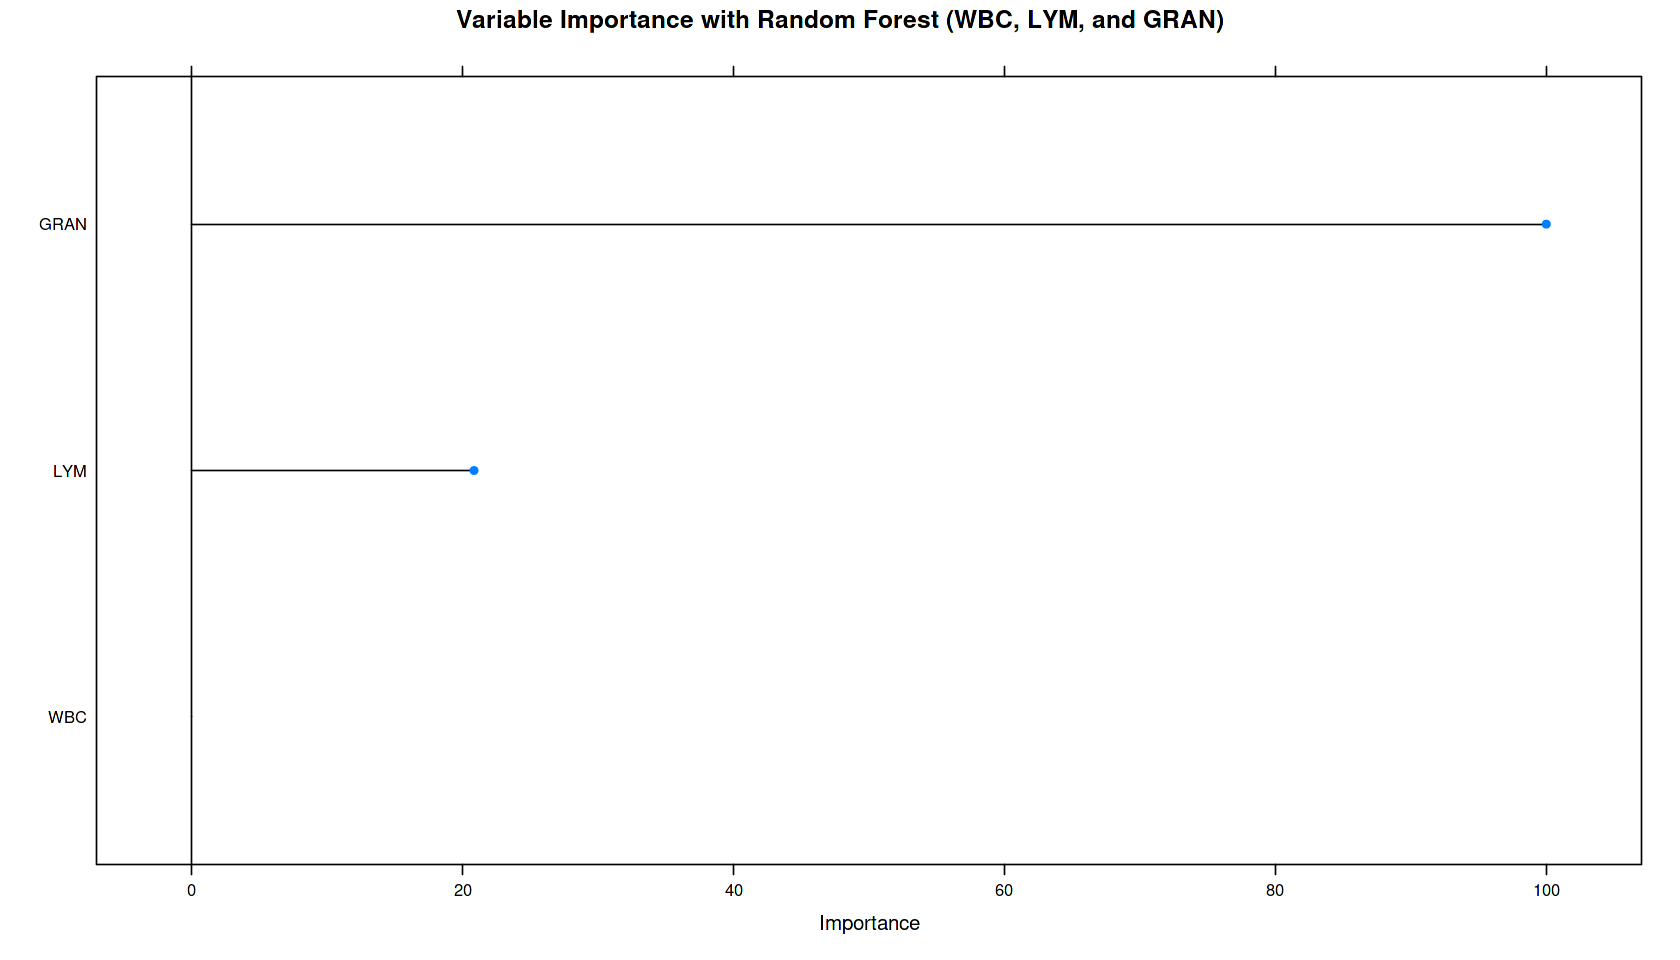

In [112]:
set.seed(100)
model_rf1 = train(Status ~ WBC + LYM + GRAN, data=trainData, method='rf', tuneLength=5, trControl = fitControl)

varimp_rf1 <- varImp(model_rf1)
plot(varimp_rf1, main="Variable Importance with Random Forest (WBC, LYM, and GRAN)")

# Training the XBoost Model with WBC, LYM, and GRAN

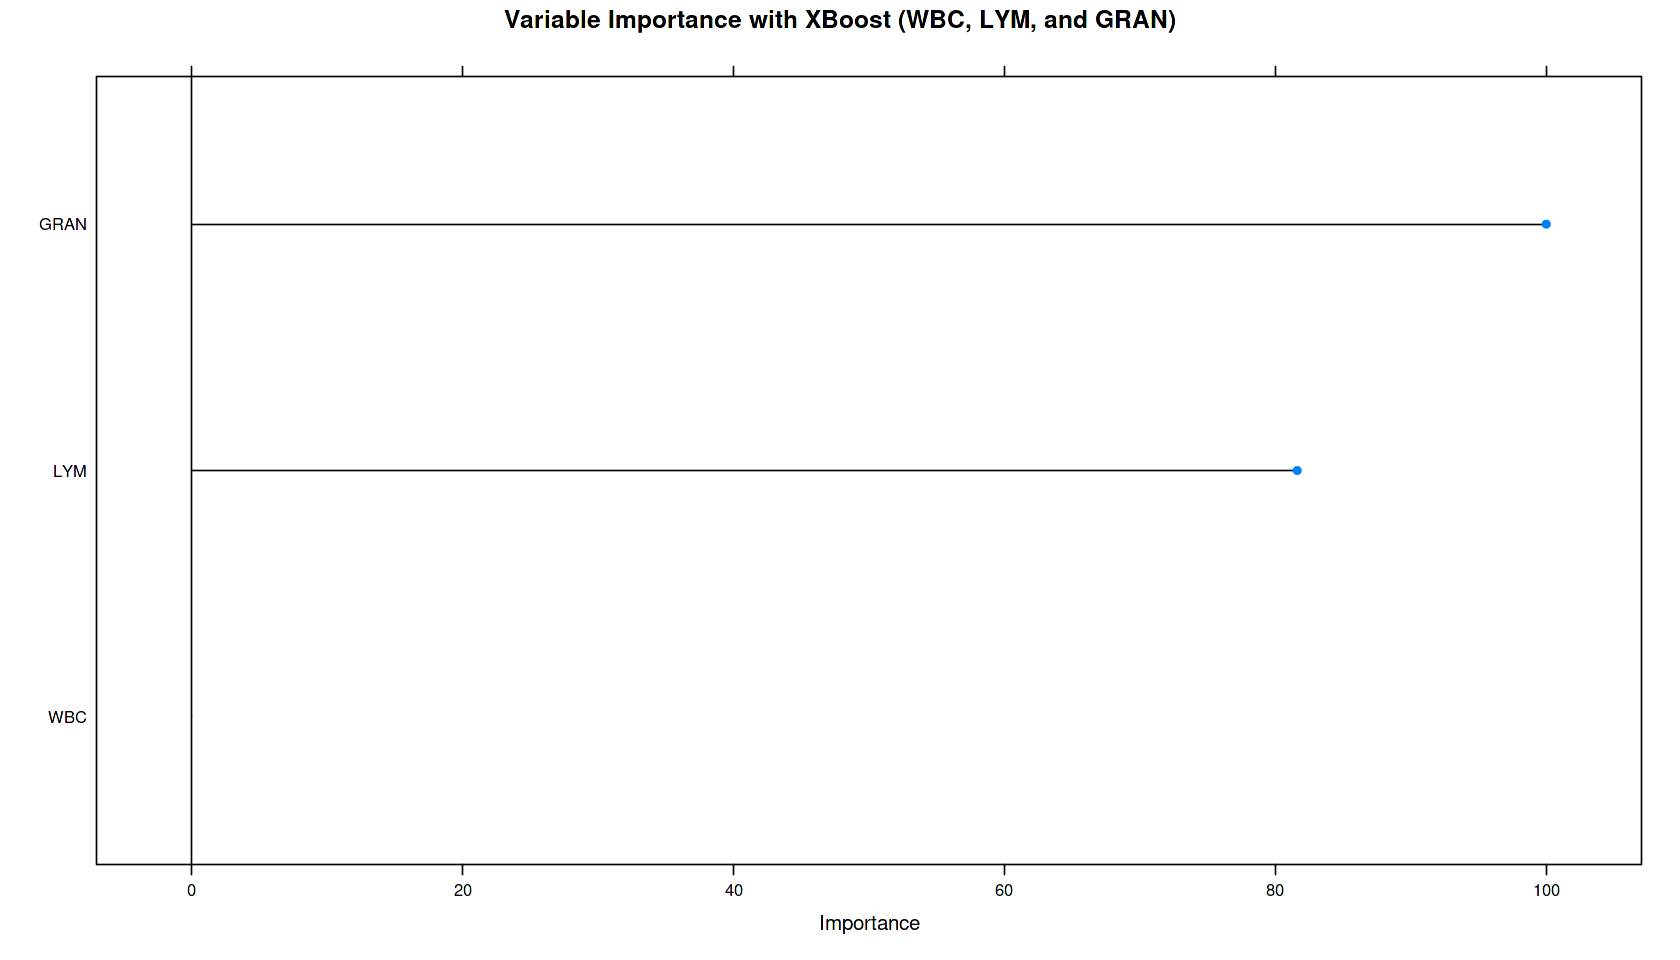

In [113]:
#XGBOOST
set.seed(100)
model_xgbTree1 = train(Status ~ WBC + LYM + GRAN, data=trainData, method='xgbTree', tuneLength=5, trControl = fitControl)
varimp_xgbTree1 <- varImp(model_xgbTree1)
plot(varimp_xgbTree1, main="Variable Importance with XBoost (WBC, LYM, and GRAN)")

Now that we have trained our four models, let us preprocess the test data

# Normalizing Test Data

In [114]:
testData$Status <- as.factor(testData$Status)
testData1 <- predict(preProcess_range_model, testData)

# View
head(testData1)

,Status,WBC,LYM,GRAN,HGB
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
6,Covid19,0.06482553,0.034297415,0.015567087,0.3925620
8,Covid19,0.02860923,0.006398771,0.015567087,0.3595041
13,Covid19,0.04365801,0.018684413,0.015196442,0.5000000
17,Covid19,0.22639325,0.030074226,0.098776872,0.2355372
19,Covid19,0.01587564,0.010877911,0.006578947,0.4504132
35,Covid19,0.13891186,0.045815203,0.043550778,0.4421488


# Predicting Test Data with Our Four (4) Models

Random Forest (Every Variable)

In [115]:
predicted_rf <- predict(model_rf, testData1)
head(predicted_rf)

[1] Covid19  Covid19  Covid19  Covid19  Negative Covid19 
Levels: Covid19 Malaria Negative

Random Forest (WBC, LYM, and GRAN)

In [116]:
predicted_rf1 <- predict(model_rf1, testData1)
head(predicted_rf1)

[1] Covid19  Covid19  Covid19  Covid19  Negative Covid19 
Levels: Covid19 Malaria Negative

XBoost (Every Variable)

In [117]:
predicted_xgbTree <- predict(model_xgbTree, testData1)
head(predicted_xgbTree)

[1] Covid19 Covid19 Covid19 Covid19 Covid19 Covid19
Levels: Covid19 Malaria Negative

XBoost (WBC, LYM, and GRAN)

In [118]:
predicted_xgbTree1 <- predict(model_xgbTree1, testData1)
head(predicted_xgbTree1)

[1] Covid19  Covid19  Covid19  Covid19  Negative Covid19 
Levels: Covid19 Malaria Negative

Now that we have made our predictions with all four models using our test data, let us make a new dataframe that consists of every prediction

In [119]:
predicted <- as.data.frame(predicted_rf)
predicted$predicted_rf1 <- predicted_rf1
predicted$predicted_xgbTree <- predicted_xgbTree
predicted$predicted_xgbTree1 <- predicted_xgbTree1
predicted$truth <- testData$Status
head(predicted)

,predicted_rf,predicted_rf1,predicted_xgbTree,predicted_xgbTree1,truth
,<fct>,<fct>,<fct>,<fct>,<fct>
1,Covid19,Covid19,Covid19,Covid19,Covid19
2,Covid19,Covid19,Covid19,Covid19,Covid19
3,Covid19,Covid19,Covid19,Covid19,Covid19
4,Covid19,Covid19,Covid19,Covid19,Covid19
5,Negative,Negative,Covid19,Negative,Covid19
6,Covid19,Covid19,Covid19,Covid19,Covid19


# Comparing Our Models with Confusion Matrices

In [120]:
confusionMatrix(reference = testData$Status, data = predicted_rf, mode='everything')

Confusion Matrix and Statistics

          Reference
Prediction Covid19 Malaria Negative
  Covid19       16       0        2
  Malaria        0      13        0
  Negative       4       0        6

Overall Statistics
                                          
               Accuracy : 0.8537          
                 95% CI : (0.7083, 0.9443)
    No Information Rate : 0.4878          
    P-Value [Acc > NIR] : 1.176e-06       
                                          
                  Kappa : 0.7705          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Covid19 Class: Malaria Class: Negative
Sensitivity                  0.8000         1.0000          0.7500
Specificity                  0.9048         1.0000          0.8788
Pos Pred Value               0.8889         1.0000          0.6000
Neg Pred Value               0.8261         1.0000          0.9355
Precision                    0.8889   

The Random Forest model with all four predicator variables has an accuracy of 0.8537.

In [121]:
confusionMatrix(reference = testData$Status, data = predicted_rf1, mode='prec_recall')

Confusion Matrix and Statistics

          Reference
Prediction Covid19 Malaria Negative
  Covid19       17       0        2
  Malaria        0      13        0
  Negative       3       0        6

Overall Statistics
                                         
               Accuracy : 0.878          
                 95% CI : (0.738, 0.9592)
    No Information Rate : 0.4878         
    P-Value [Acc > NIR] : 1.806e-07      
                                         
                  Kappa : 0.8066         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Covid19 Class: Malaria Class: Negative
Precision                    0.8947         1.0000          0.6667
Recall                       0.8500         1.0000          0.7500
F1                           0.8718         1.0000          0.7059
Prevalence                   0.4878         0.3171          0.1951
Detection Rate               0.4146         0.3

The Random Forest model with just three predicator variables has an accuracy of 0.878. This means that the model performed better when HGB was removed.

In [122]:
confusionMatrix(reference = testData$Status, data = predicted_xgbTree, mode='prec_recall')

Confusion Matrix and Statistics

          Reference
Prediction Covid19 Malaria Negative
  Covid19       17       0        1
  Malaria        0      13        0
  Negative       3       0        7

Overall Statistics
                                          
               Accuracy : 0.9024          
                 95% CI : (0.7687, 0.9728)
    No Information Rate : 0.4878          
    P-Value [Acc > NIR] : 2.253e-08       
                                          
                  Kappa : 0.847           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Covid19 Class: Malaria Class: Negative
Precision                    0.9444         1.0000          0.7000
Recall                       0.8500         1.0000          0.8750
F1                           0.8947         1.0000          0.7778
Prevalence                   0.4878         0.3171          0.1951
Detection Rate               0.4146   

The XBoost model with all four predicator variables has an accuracy of 0.9024. This model performed better than both Random Forest models.

In [123]:
confusionMatrix(reference = testData$Status, data = predicted_xgbTree1, mode='prec_recall')

Confusion Matrix and Statistics

          Reference
Prediction Covid19 Malaria Negative
  Covid19       16       0        2
  Malaria        0      13        0
  Negative       4       0        6

Overall Statistics
                                          
               Accuracy : 0.8537          
                 95% CI : (0.7083, 0.9443)
    No Information Rate : 0.4878          
    P-Value [Acc > NIR] : 1.176e-06       
                                          
                  Kappa : 0.7705          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Covid19 Class: Malaria Class: Negative
Precision                    0.8889         1.0000          0.6000
Recall                       0.8000         1.0000          0.7500
F1                           0.8421         1.0000          0.6667
Prevalence                   0.4878         0.3171          0.1951
Detection Rate               0.3902   

The XBoost model with just three predicator variables has an accuracy of 0.8537. This means that the model performed worst when HGB was removed.

# Comparing Our Models with Graphics

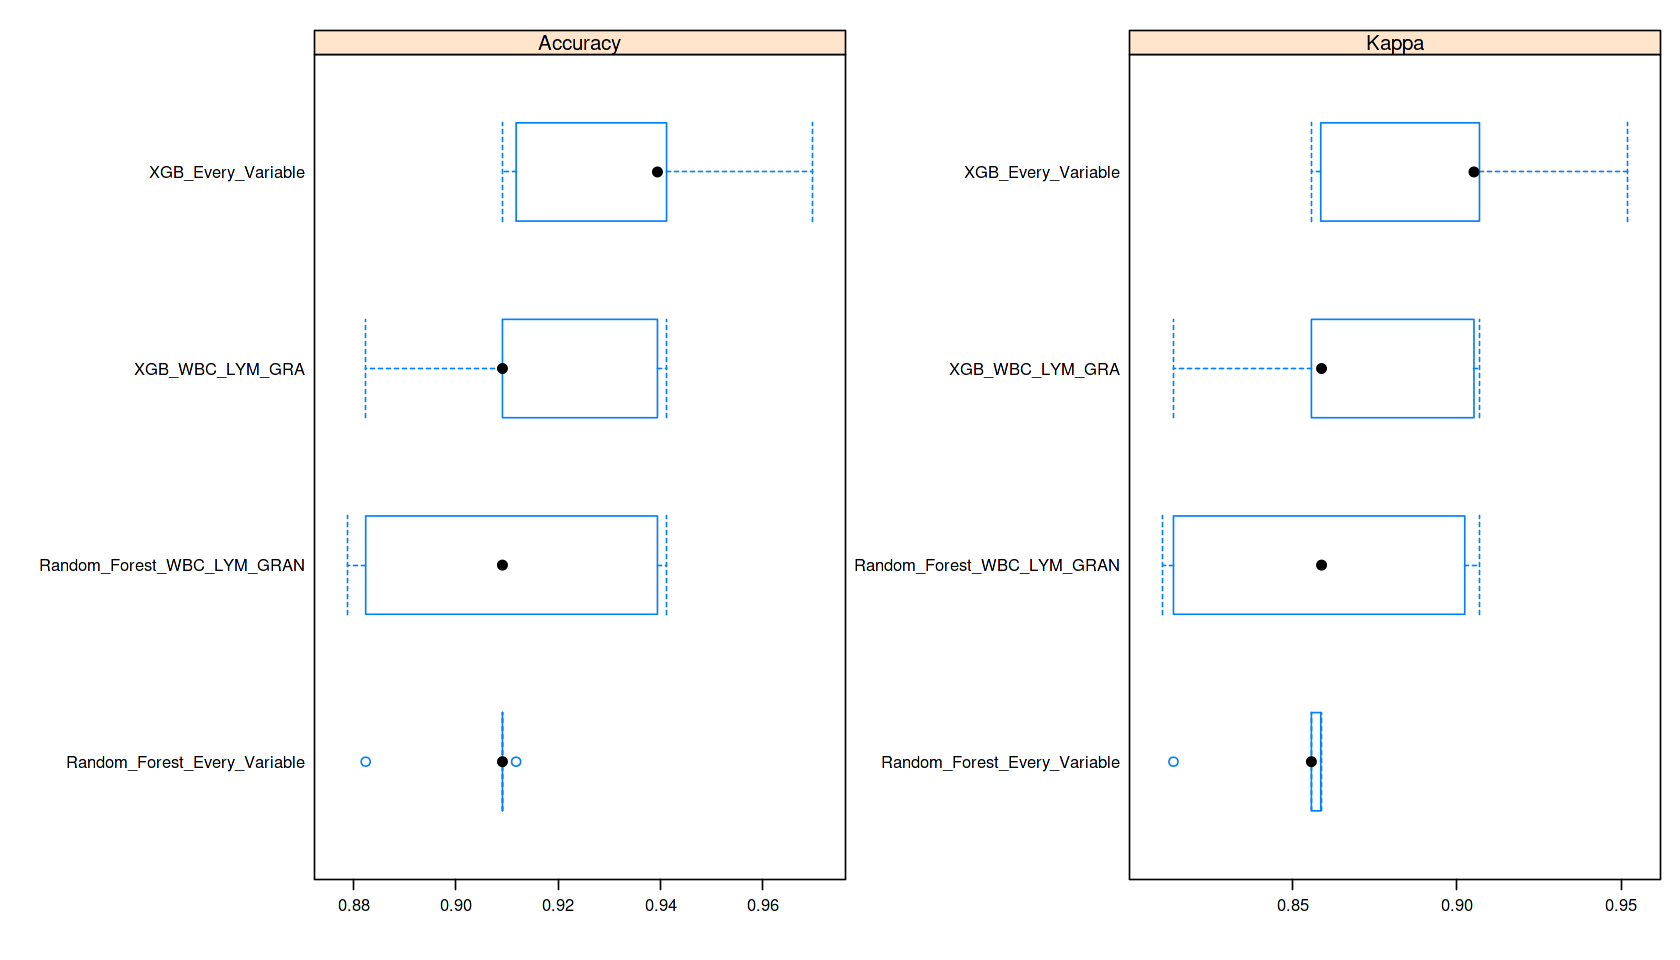

In [124]:
# Compare model performances using resample()
models_compare <- resamples(list(Random_Forest_Every_Variable=model_rf, XGB_Every_Variable = model_xgbTree, Random_Forest_WBC_LYM_GRAN = model_rf1, XGB_WBC_LYM_GRA = model_xgbTree1))


# Draw box plots to compare models
scales <- list(x=list(relation="free"), y=list(relation="free"))
bwplot(models_compare, scales=scales)

It seems that the random forest performed better and the XBoost performed worst when the HGB is removed. It means that we should try different models as well as try various predicators (whether EDA approve of them or not).

# **Conclusion**

It is possible to tell the covid-19/malaria status of a patient by examining their lymphocytes, granulocytes, hemoglobin, and total white blood cells in the blood. With accuracies of over 80% we can trust our models. We, however, still have to do the real lab test to be 100% sure.

I wish you safety. Stay Safe.

# **Acknowledgements**

I wish to acknowledge my classmates Ikechukwu Noble, Juliet Opene, and Valentine Onwusoroaka who collected data for this analysis.